In [ ]:
# ─────────────── Evaluate on UNSEEN (test) data ───────────────

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Load model
weights = "Road_Damage/final_model/best_fold.pt"
model   = YOLO(weights)

# 2. Prepare class indices (excluding "no_damage")
names = model.names.copy()
name_to_idx = {v: k for k, v in names.items()}
folders = list(name_to_idx.keys())  # e.g., ['potholes', 'crack_issues', ...]

# 3. Evaluate
root = "Road_Damage/test"
print(f"Evaluating UNSEEN (test) at: {root!r}\n")

y_true, y_pred = [], []
for fld in folders:
    img_dir = os.path.join(root, fld, "images")
    if not os.path.isdir(img_dir): 
        continue
    for fn in sorted(os.listdir(img_dir)):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        y_true.append(name_to_idx[fld])
        res = model(os.path.join(img_dir, fn), imgsz=640)[0]
        top_idx = int(res.probs.top1)
        y_pred.append(top_idx)

# 4. Report & plot
labels = sorted(name_to_idx.values())
target_names = [names[i] for i in labels]

print("📊 Unseen (test) Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=target_names,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


Available columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
No plateau detected with given window/tol settings.


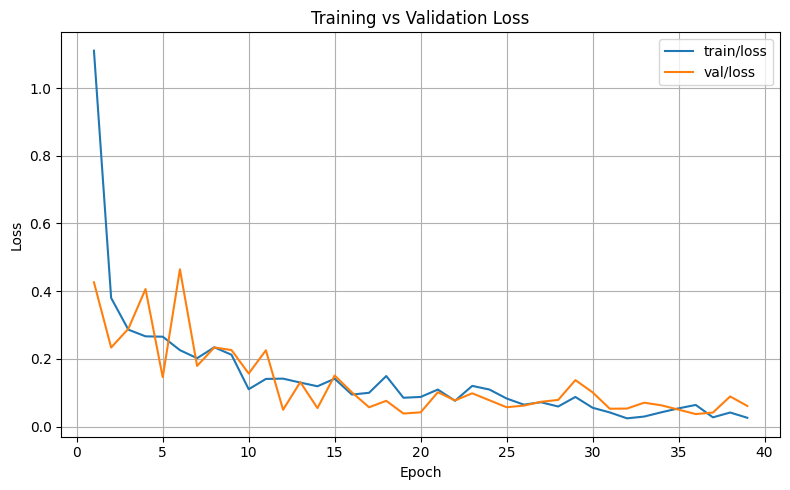

In [1]:
#TRAINING VS VALIDATION LOSS
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Path to the directory containing your fold metrics CSVs
FOLD_DIR = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2"
METRICS_CSV = os.path.join(FOLD_DIR, 'results.csv')

# --- FUNCTIONS ---
def load_metrics(csv_path):
    """
    Load training metrics CSV into a pandas DataFrame.
    Adds an 'epoch' column if missing and logs available columns.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Metrics file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    if 'epoch' not in df.columns:
        df.insert(0, 'epoch', df.index + 1)
    print("Available columns:", df.columns.tolist())
    return df


def identify_loss_columns(df):
    """
    Return a dict mapping loss types ('train', 'val') to their column names if present.
    """
    loss_cols = {}
    for typ in ['train/loss', 'val/loss']:
        loss_cols[typ] = typ if typ in df.columns else None
    return loss_cols


def plot_loss_curves(df, loss_cols):
    """
    Plot training and validation losses over epochs.
    """
    plt.figure(figsize=(8,5))
    for typ, col in loss_cols.items():
        if col:
            plt.plot(df['epoch'], df[col], label=col)
        else:
            print(f"Warning: Column '{typ}' not found and will not be plotted.")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)


def detect_plateau_epoch(df, col, window=5, tol=1e-3):
    """
    Detect first epoch where the loss change over 'window' epochs is below 'tol'.
    Returns epoch number or None.
    """
    if col not in df.columns:
        return None
    values = df[col].values
    for i in range(len(values) - window):
        win = values[i:i+window]
        if max(win) - min(win) < tol:
            return int(df.loc[i, 'epoch'])
    return None


def annotate_plateau(epoch):
    """
    Draw a vertical line at the plateau epoch.
    """
    if epoch:
        plt.axvline(x=epoch, color='red', linestyle='--',
                    label=f'Plateau at epoch {epoch}')
        plt.legend()
    else:
        print("No plateau detected with given window/tol settings.")


if __name__ == '__main__':
    # Load data
    df = load_metrics(METRICS_CSV)

    # Identify loss columns
    losses = identify_loss_columns(df)

    # Plot
    plot_loss_curves(df, losses)

    # Detect plateau on training loss
    plateau_epoch = detect_plateau_epoch(df, 'train/loss', window=5, tol=1e-3)
    annotate_plateau(plateau_epoch)

    # Finalize plot
    plt.tight_layout()
    plt.show()


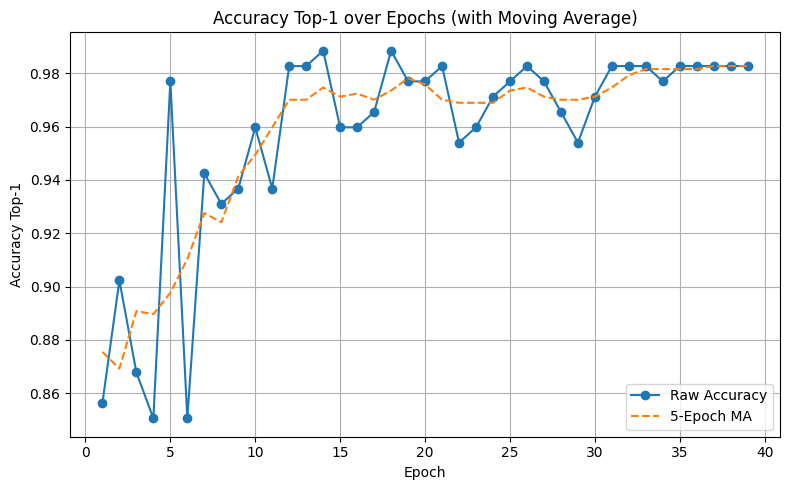

In [2]:
#Accuracy Top-1 over Epochs (with Moving Average)
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
FOLD_DIR = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_4\results2"
METRICS_CSV = os.path.join(FOLD_DIR, 'results.csv')
SMOOTH_WINDOW = 5  # number of epochs for moving average smoothing

# --- FUNCTIONS ---
def load_metrics(csv_path):
    """
    Load the metrics CSV into a DataFrame, ensuring an 'epoch' column exists.
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Metrics file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    if 'epoch' not in df.columns:
        df.insert(0, 'epoch', df.index + 1)
    return df


def plot_accuracy_with_smoothing(df, acc_col='metrics/accuracy_top1', window=SMOOTH_WINDOW):
    """
    Plot raw accuracy and a smoothed moving average over epochs.
    """
    if acc_col not in df.columns:
        raise KeyError(f"Column '{acc_col}' not found in DataFrame.")

    epochs = df['epoch']
    accuracy = df[acc_col]
    smooth = accuracy.rolling(window=window, min_periods=1, center=True).mean()

    plt.figure(figsize=(8,5))
    plt.plot(epochs, accuracy, marker='o', label='Raw Accuracy', color='tab:blue')
    plt.plot(epochs, smooth, linestyle='--', label=f'{window}-Epoch MA', color='tab:orange')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Top-1')
    plt.title('Accuracy Top-1 over Epochs (with Moving Average)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    df = load_metrics(METRICS_CSV)
    plot_accuracy_with_smoothing(df)


In [ ]:
# ─────────────── Evaluate on UNSEEN (test) data ───────────────

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Load model
weights = "Road_Damage/final_model/best_fold.pt"
model   = YOLO(weights)

# 2. Prepare class indices (excluding "no_damage")
names = model.names.copy()
name_to_idx = {v: k for k, v in names.items()}
folders = list(name_to_idx.keys())  # e.g., ['potholes', 'crack_issues', ...]

# 3. Evaluate
root = "Road_Damage/test"
print(f"Evaluating UNSEEN (test) at: {root!r}\n")

y_true, y_pred = [], []
for fld in folders:
    img_dir = os.path.join(root, fld, "images")
    if not os.path.isdir(img_dir): 
        continue
    for fn in sorted(os.listdir(img_dir)):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        y_true.append(name_to_idx[fld])
        res = model(os.path.join(img_dir, fn), imgsz=640)[0]
        top_idx = int(res.probs.top1)
        y_pred.append(top_idx)

# 4. Report & plot
labels = sorted(name_to_idx.values())
target_names = [names[i] for i in labels]

print("📊 Unseen (test) Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=target_names,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


Model classes: {0: 'alligator_crack_issues', 1: 'crack_issues', 2: 'open_manhole', 3: 'potholes', 4: 'ravelling'}
Number of classes: 5
Evaluating UNSEEN (test) at: 'Road_Damage/test'

📊 Unseen (test) Classification Report:

                        precision    recall  f1-score   support

alligator_crack_issues       1.00      0.50      0.67         8
          crack_issues       0.75      0.90      0.82        10
          open_manhole       1.00      1.00      1.00         9
              potholes       1.00      0.86      0.92         7
             ravelling       0.75      1.00      0.86         9

              accuracy                           0.86        43
             macro avg       0.90      0.85      0.85        43
          weighted avg       0.89      0.86      0.85        43



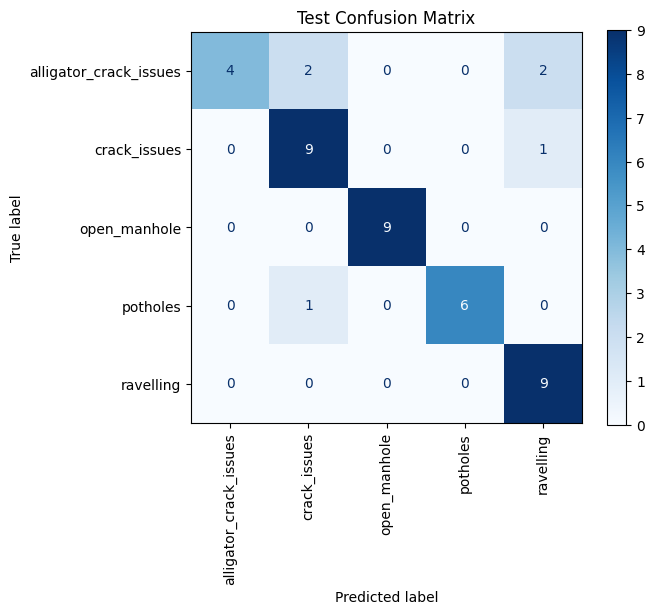

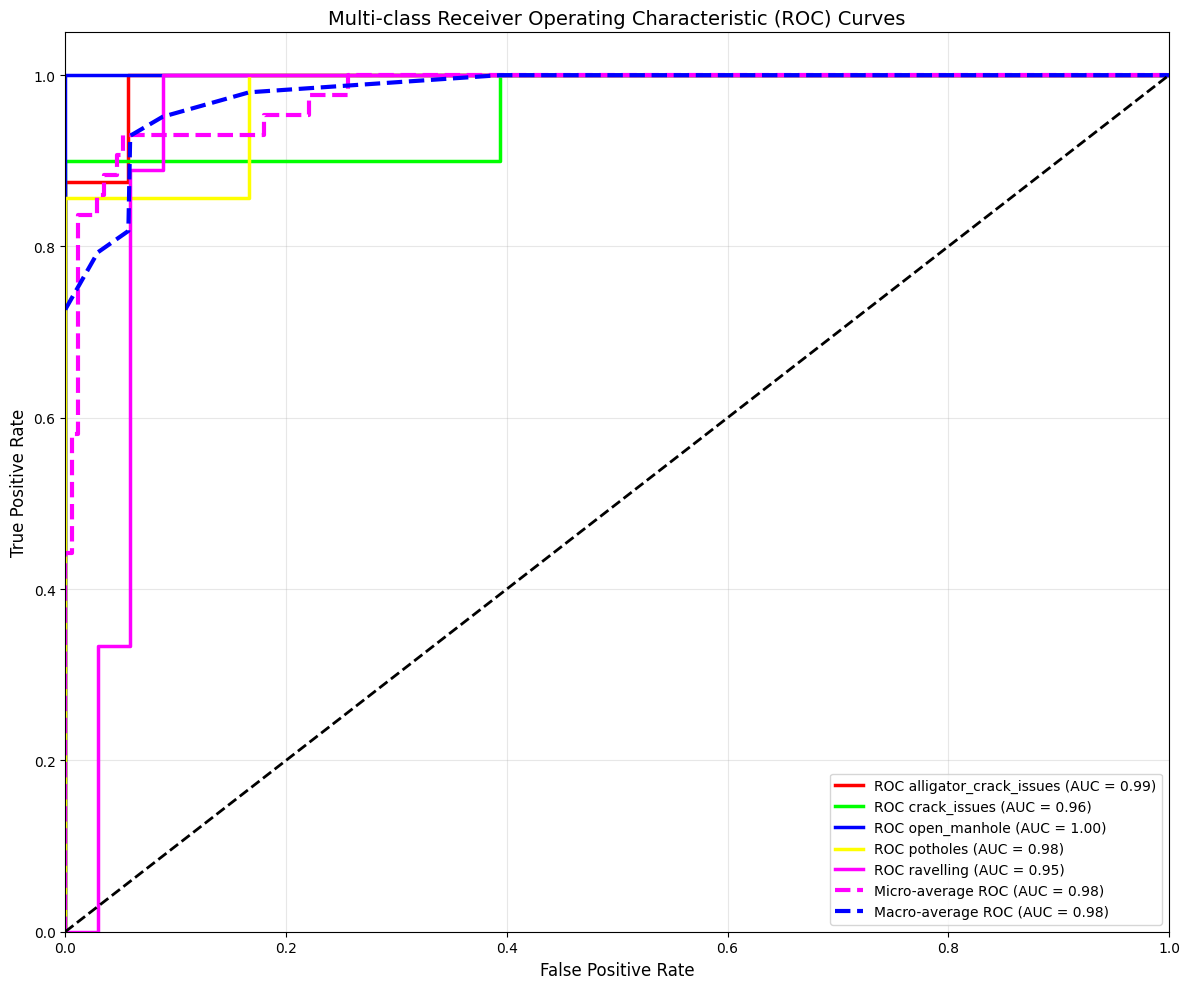


 ROC AUC Scores:
AUC for alligator_crack_issues: 0.9929
AUC for crack_issues: 0.9606
AUC for open_manhole: 1.0000
AUC for potholes: 0.9762
AUC for ravelling: 0.9477
Micro-average AUC: 0.9771
Macro-average AUC: 0.9806


In [9]:
#ROC CURVE
from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np # Import numpy
import os

# 1. Load model
weights = "Road_Damage/final_model/best_fold.pt"
model   = YOLO(weights)

# 2. Prepare class indices
names = model.names.copy()
name_to_idx = {v: k for k, v in names.items()}
# Ensure that the classes you want to evaluate are present in your test set structure
# If "no_damage" should be excluded from ROC evaluation as well, make sure it's handled.
# For ROC, we usually evaluate all classes for which we have predictions.
folders = list(name_to_idx.keys())
num_classes = len(names)
print(f"Model classes: {names}")
print(f"Number of classes: {num_classes}")

# 3. Evaluate and Collect Scores
root = "Road_Damage/test"
print(f"Evaluating UNSEEN (test) at: {root!r}\n")

y_true_indices = []
y_pred_indices = []
y_pred_scores = [] # To store probability scores for ROC

for fld in folders:
    img_dir = os.path.join(root, fld, "images")
    if not os.path.isdir(img_dir):
        print(f"Warning: Directory not found for class '{fld}', skipping: {img_dir}")
        continue
    if fld not in name_to_idx:
        print(f"Warning: Class '{fld}' from directory structure not in model names, skipping.")
        continue

    true_class_idx = name_to_idx[fld]
    for fn in sorted(os.listdir(img_dir)):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        
        image_path = os.path.join(img_dir, fn)
        try:
            res = model(image_path, imgsz=640, verbose=False)[0] # Added verbose=False for cleaner output
            
            # Store true class index
            y_true_indices.append(true_class_idx)
            
            # Store predicted class index (for confusion matrix and classification report)
            top_idx = int(res.probs.top1)
            y_pred_indices.append(top_idx)
            
            # Store predicted probabilities for all classes (for ROC)
            # res.probs.data should be a tensor of shape [num_classes]
            # We need to ensure it's correctly ordered according to model.names
            # YOLO's res.probs.data is already ordered by class index
            y_pred_scores.append(res.probs.data.cpu().numpy())

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue

if not y_true_indices:
    print("No test data found or processed. Exiting.")
    exit()

# Convert lists to numpy arrays
y_true_indices = np.array(y_true_indices)
y_pred_indices = np.array(y_pred_indices)
y_pred_scores = np.array(y_pred_scores)

# 4. Report & Confusion Matrix (as before)
labels = sorted(name_to_idx.values()) # These are the actual indices used
target_names_report = [names[i] for i in labels if i in names] # Ensure only valid names

print("📊 Unseen (test) Classification Report:\n")
print(classification_report(
    y_true_indices, y_pred_indices,
    labels=labels, # Use the sorted indices
    target_names=target_names_report,
    zero_division=0
))

cm = confusion_matrix(y_true_indices, y_pred_indices, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names_report)
fig, ax = plt.subplots(figsize=(7, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


# 5. Generate and Plot ROC Curves

# Binarize the y_true labels for OvR ROC curve calculation
y_true_binarized = label_binarize(y_true_indices, classes=list(range(num_classes)))

# Check if binarization produced the expected number of columns
if y_true_binarized.shape[1] != num_classes:
    print(f"Warning: Mismatch in binarized columns ({y_true_binarized.shape[1]}) vs num_classes ({num_classes}).")
    print("This might happen if some classes had no samples in the test set.")
    # Adjust num_classes for ROC plotting if necessary, or ensure y_pred_scores columns match
    # For simplicity, we'll proceed assuming y_pred_scores has num_classes columns
    # and those missing in y_true_binarized will result in non-informative ROCs.

# Dictionary to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

# target_names_roc should correspond to the columns of y_pred_scores and y_true_binarized
target_names_roc = [names[i] for i in range(num_classes)]

for i in range(num_classes):
    if i < y_true_binarized.shape[1] and y_true_binarized[:, i].any(): # Check if column exists and has at least one positive sample
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        # This class was not in y_true, had no positive samples, or label_binarize didn't create a column for it
        fpr[i], tpr[i], roc_auc[i] = np.array([0, 1]), np.array([0, 1]), 0.0 # Default non-informative ROC
        if i >= y_true_binarized.shape[1]:
             print(f"Warning: Class {target_names_roc[i]} (index {i}) was not present in y_true_binarized columns. Assigning default ROC.")
        else:
             print(f"Warning: Class {target_names_roc[i]} (index {i}) had no positive samples in the test set. Assigning default ROC.")


# Plot all OvR ROC curves
plt.figure(figsize=(12, 10)) # Slightly larger figure for better legend visibility

# Use matplotlib.colormaps for new versions
try:
    colormap = plt.colormaps.get_cmap('tab20')  # tab20 is good for distinct colors
except AttributeError: # Fallback for older Matplotlib versions
    colormap = plt.cm.get_cmap('tab20')

# If num_classes is large, tab20 might repeat. For very many classes, consider 'hsv' or manual colors.
# We'll generate distinct colors. If num_classes > 20, colors will start repeating from tab20.
# You can define a custom list of bright colors if needed:
custom_bright_colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
    '#FF6347', '#7FFF00', '#1E90FF', '#FFD700', '#DA70D6', '#00FA9A',
    '#FF4500', '#32CD32', '#4169E1', '#FF8C00', '#9932CC', '#20B2AA'
] # Add more as needed

line_thickness = 2.5 # Increased line thickness

for i in range(num_classes):
    color_idx = i % len(custom_bright_colors) # Cycle through custom bright colors
    current_color = custom_bright_colors[color_idx]
    # If you prefer colormap (like tab20, which is good for up to 20 classes):
    # current_color = colormap(i / num_classes if num_classes > 1 else 0)


    if roc_auc.get(i, 0.0) > 0.0 and len(fpr.get(i, [])) > 1:
        plt.plot(fpr[i], tpr[i], color=current_color, lw=line_thickness,
                 label=f'ROC {target_names_roc[i]} (AUC = {roc_auc[i]:0.2f})')
    elif roc_auc.get(i, 0.0) == 0.0 and len(fpr.get(i,[])) > 1:
         plt.plot(fpr[i], tpr[i], color=current_color, lw=line_thickness, linestyle=':',
                 label=f'ROC {target_names_roc[i]} (AUC = {roc_auc[i]:0.2f} - possibly no positive samples)')

# Plot micro-average ROC curve
y_true_flat = y_true_binarized.ravel()
y_pred_scores_flat = y_pred_scores.ravel()

if len(y_true_flat) > 0 and len(y_pred_scores_flat) > 0:
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_flat, y_pred_scores_flat)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (AUC = {roc_auc["micro"]:0.2f})',
             color='magenta', linestyle='--', linewidth=line_thickness + 0.5) # Thicker and distinct
else:
    print("Warning: Not enough data to plot micro-average ROC curve.")

# Plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes) if i in fpr and len(fpr[i]) > 1]))

if len(all_fpr) > 0: # Ensure all_fpr is not empty
    mean_tpr = np.zeros_like(all_fpr)
    valid_classes_for_macro = 0
    for i in range(num_classes):
        if i in fpr and len(fpr[i]) > 1:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
            valid_classes_for_macro +=1

    if valid_classes_for_macro > 0:
        mean_tpr /= valid_classes_for_macro
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC (AUC = {roc_auc["macro"]:0.2f})',
                 color='blue', linestyle='--', linewidth=line_thickness + 0.5) # Thicker and distinct
    else:
        print("Warning: Not enough valid per-class ROC curves to compute macro-average.")
else:
    print("Warning: No valid FPR points to compute macro-average ROC curve.")


plt.plot([0, 1], [0, 1], 'k--', lw=line_thickness - 0.5) # Random chance line, slightly thinner
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curves', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3) # Add a light grid for better readability
plt.tight_layout()
plt.show()

print("\n ROC AUC Scores:")
for i in range(num_classes):
    if i in roc_auc and i < len(target_names_roc): # Ensure index is valid for target_names_roc
        # Corrected line:
        print(f"AUC for {target_names_roc[i]}: {roc_auc[i]:.4f}")
    elif i in roc_auc:
        # Fallback if target_names_roc doesn't align, though it should
        print(f"AUC for class index {i}: {roc_auc[i]:.4f}")

if "micro" in roc_auc:
    print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
if "macro" in roc_auc:
    print(f"Macro-average AUC: {roc_auc['macro']:.4f}")
